# TSAnnotatedTensor

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from config import *

base_dir: /media/big_ssd/doug/Documents/GitHub/NonPatch
added path: /media/big_ssd/doug/Documents/GitHub/NonPatch/src
added path: /media/big_ssd/doug/Documents/GitHub/NonPatch/src/contrib


In [3]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

/home/doug/anaconda3/envs/tsai2/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


tsai       : 0.2.16
fastai     : 2.2.7
fastcore   : 1.3.19
torch      : 1.7.0


# Code

In [4]:
class TSAnnotatedTensor(TSTensor):
    def __init__(self, *args,ann=[], **kwargs):
        TSTensor.__init__(*args, **kwargs)
        self.ann = ann
        
    def __repr__(self):
        if self.numel() == 1: return f'{self}'
        elif self.ndim >= 3:
            return f'TSAnnTensor(samples:{self.shape[-3]}, vars:{self.shape[-2]}, len:{self.shape[-1]}, ann:{len(self.ann)})'
        elif self.ndim == 2:
            return f'TSAnnTensor(vars:{self.shape[-2]}, len:{self.shape[-1]}, ann:{len(self.ann)})'
        elif self.ndim == 1:
            return f'TSAnnTensor(len:{self.shape[-1]}, ann:{len(self.ann)})'

In [5]:
class TSAnnotatedDataset(TSDataset):
    def __init__(self, X, y=None, types=None, sel_vars=None, sel_steps=None, anns=None):
        assert types is None or types[0] == TSAnnotatedTensor
        self.X, self.y, self.types, self.anns = to3darray(X), y, types, anns
        self.sel_vars = ifnone(sel_vars, slice(None))
        self.sel_steps = ifnone(sel_steps,slice(None))
        
        self.first = True
        
    def __getitem__(self, idx):
        
        if self.first:
            self.first = False
            print('idx', idx, 'anns', self.anns)
            #print('self.sel_vars, self.sel_steps', self.sel_vars, self.sel_steps)
        
        a = self.anns[idx] if self.anns is not None else []
        
        _x = TSAnnotatedTensor(self.X[idx, self.sel_vars, self.sel_steps], ann=a)
        if self.types is None or self.y is None:
            return (_x, self.y[idx]) if self.y is not None else (_x)
        else:
            return (_x, self.types[1](self.y[idx])) if self.y is not None else (_x)

# Analysis

## Test TSAnnotatedTensor

In [6]:
inp = np.arange(10).reshape((2, 5))
a = TSAnnotatedTensor(inp, ann=[3,5])
a, a.data, a.ann

(TSAnnTensor(vars:2, len:5, ann:2),
 tensor([[0, 1, 2, 3, 4],
         [5, 6, 7, 8, 9]]),
 [3, 5])

In [7]:
inp = np.arange(10).reshape((1, 10))
a = TSAnnotatedTensor(inp, ann=[3,5])
a, a.data, a.ann

(TSAnnTensor(vars:1, len:10, ann:2),
 tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),
 [3, 5])

In [8]:
a.len, a.vars

(10, 1)

In [9]:
y = [True, False]*5

In [10]:
X = np.arange(100).reshape((10,2, 5))

In [11]:
ds = TSDataset(X, y, types=[TSAnnotatedTensor, NumpyTensor])

In [12]:
ds[0][0]

TSAnnTensor(vars:2, len:5, ann:0)

In [13]:
ds[0][1], type(ds[0][1])

(True, tsai.data.core.NumpyTensor)

In [14]:
x = np.arange(100).reshape((10,2, 5))
x.shape

(10, 2, 5)

## Test TSAnnotatedDataset

In [15]:
tsad = TSAnnotatedDataset(x, anns=[[1]]*5)
tsad, tsad[0], tsad[0].data

idx 0 anns [[1], [1], [1], [1], [1]]


(<__main__.TSAnnotatedDataset at 0x7efd4caa1400>,
 TSAnnTensor(vars:2, len:5, ann:1),
 tensor([[0, 1, 2, 3, 4],
         [5, 6, 7, 8, 9]]))

In [16]:
tsad = TSAnnotatedDataset(x)
tsad, tsad[0], #tsad[0].data

idx 0 anns None


(<__main__.TSAnnotatedDataset at 0x7efd4caa1700>,
 TSAnnTensor(vars:2, len:5, ann:0))

### Try on something larger

In [17]:
dsid = 'StarLightCurves'
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=False)

Dataset: StarLightCurves
X_train: (1000, 1, 1024)
y_train: (1000,)
X_valid: (8236, 1, 1024)
y_valid: (8236,) 



#### Reference: TSDataset

In [18]:
train_ds = TSDataset(np.array(X_train), np.array(y_train).astype(int) - 1, types=(TSTensor, TensorCategory))
train_dl = DataLoader(train_ds, bs=128, num_workers=0)
valid_ds = TSDataset(np.array(X_valid), np.array(y_valid).astype(int) - 1, types=(TSTensor, TensorCategory))
valid_dl = DataLoader(valid_ds, bs=128, num_workers=0)
dls      = DataLoaders(train_dl, valid_dl, device=default_device())
xb,yb = next(iter(dls.valid))
print(xb, yb)
print(f'shape: {str(len(train_ds)):10}   bs: {xb.shape}')
%timeit cycle_dl(dls.valid)

TSTensor(samples:128, vars:1, len:1024) TensorCategory([1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2,
        1, 0, 2, 0, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 2,
        2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2,
        1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2,
        2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2,
        2, 2, 2, 2, 1, 2, 2, 0])
shape: 1000         bs: (128, 1, 1024)
593 ms ± 4.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Try using TSAnnotatedDataset

In [19]:
train_ds = TSAnnotatedDataset(np.array(X_train), np.array(y_train).astype(int) - 1, types=(TSAnnotatedTensor, TensorCategory))
train_dl = DataLoader(train_ds, bs=128, num_workers=0)
valid_ds = TSAnnotatedDataset(np.array(X_valid), np.array(y_valid).astype(int) - 1, types=(TSAnnotatedTensor, TensorCategory))
valid_dl = DataLoader(valid_ds, bs=128, num_workers=0)
dls      = DataLoaders(train_dl, valid_dl, device=default_device())
xb,yb = next(iter(dls.valid))
print(xb, yb)
print(f'shape: {str(len(train_ds)):10}   bs: {xb.shape}')
%timeit cycle_dl(dls.valid)

idx 0 anns None
TSAnnTensor(samples:128, vars:1, len:1024, ann:0) TensorCategory([1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2,
        1, 0, 2, 0, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 2,
        2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2,
        1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2,
        2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2,
        2, 2, 2, 2, 1, 2, 2, 0])
shape: 1000         bs: (128, 1, 1024)
611 ms ± 4.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Add positions

In [20]:
def get_dummy_annotations(X, window_size=50, n_pos=4):
    return np.random.randint(window_size//2, X.shape[-1]-window_size//2, size=(len(X), n_pos))

In [21]:
ann_train = get_dummy_annotations(X_train)
ann_valid = get_dummy_annotations(X_valid)
ann_train.shape, ann_valid.shape

((1000, 4), (8236, 4))

In [22]:
train_ds = TSAnnotatedDataset(np.array(X_train), np.array(y_train).astype(int) - 1, anns=ann_train,
                              types=(TSAnnotatedTensor, TensorCategory))
train_dl = DataLoader(train_ds, bs=128, num_workers=0)
valid_ds = TSAnnotatedDataset(np.array(X_valid), np.array(y_valid).astype(int) - 1, anns=ann_valid,
                              types=(TSAnnotatedTensor, TensorCategory))
valid_dl = DataLoader(valid_ds, bs=128, num_workers=0)
dls      = DataLoaders(train_dl, valid_dl, device=default_device())
xb,yb = next(iter(dls.valid))
print(xb, yb)
print(f'shape: {str(len(train_ds)):10}   bs: {xb.shape}')
%timeit cycle_dl(dls.valid)

idx 0 anns [[218  94 108 945]
 [624 773 672 835]
 [975 458 232 458]
 ...
 [229 233 911 681]
 [293 748 281 847]
 [280 650 669 167]]
TSAnnTensor(samples:128, vars:1, len:1024, ann:4) TensorCategory([1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2,
        1, 0, 2, 0, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 2,
        2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2,
        1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2,
        2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2,
        2, 2, 2, 2, 1, 2, 2, 0])
shape: 1000         bs: (128, 1, 1024)
612 ms ± 6.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
xb,yb = next(iter(train_ds))
print(type(xb), type(yb))
xb,yb, xb.ann.shape

idx 0 anns [[823 359 931 207]
 [415 458 514 782]
 [948 579  43 207]
 ...
 [579 560 533 926]
 [242 586 133 755]
 [806 490 226 755]]
<class '__main__.TSAnnotatedTensor'> <class 'fastai.torch_core.TensorCategory'>


(TSAnnTensor(vars:1, len:1024, ann:4), TensorCategory(2), (4,))

<AxesSubplot:>

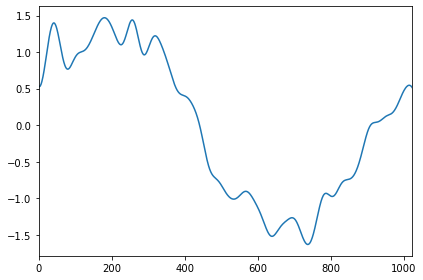

In [24]:
xb.show()

In [25]:
xb,yb = next(iter(dls.valid))
print(type(xb), type(yb))
xb,yb

<class '__main__.TSAnnotatedTensor'> <class 'fastai.torch_core.TensorCategory'>


(TSAnnTensor(samples:128, vars:1, len:1024, ann:4),
 TensorCategory([1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2,
         1, 0, 2, 0, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 2,
         2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2,
         1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2,
         2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2,
         2, 2, 2, 2, 1, 2, 2, 0]))

<AxesSubplot:>

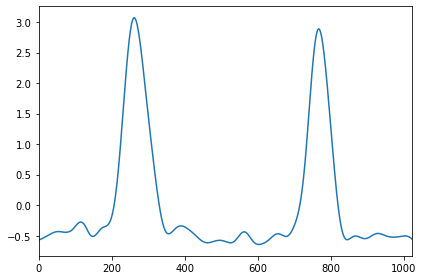

In [26]:
xb.show()

In [27]:
xb.ann

array([218,  94, 108, 945])

## Random Window

In [28]:
def random_select_from_nparray(ann_arr):
    shape = ann_arr.shape
    n, m = ann_arr.shape[0], ann_arr.shape[-1]
    if len(shape) == 1:
        idx = np.random.randint(m)
        return ann_arr[idx]
    else:
        idx = np.random.randint(m, size=n)
        return ann_arr[np.arange(n), idx]

def random_select_from_list(ann_arr):
    if isinstance(ann_arr[0], list):
        #print('', [len(x) for x in ann_arr])
        return [x[np.random.randint(len(x))] for x in ann_arr]
    else:
        return ann_arr[np.random.randint(len(ann_arr))]

#### Test Numpy Selection

In [29]:
ll = np.arange(10)
print(ll)
print(random_select_from_nparray(ll))
print(random_select_from_nparray(ll))
print(random_select_from_nparray(ll))
print(random_select_from_nparray(ll))

[0 1 2 3 4 5 6 7 8 9]
8
2
7
9


In [30]:
ll = np.arange(27).reshape((3, 9))
print(ll)
print(random_select_from_nparray(ll))
print(random_select_from_nparray(ll))
print(random_select_from_nparray(ll))
print(random_select_from_nparray(ll))

[[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]
 [18 19 20 21 22 23 24 25 26]]
[ 8 10 22]
[ 3 14 21]
[ 1 13 22]
[ 7 13 26]


#### Test List Selection

In [31]:
ll = list(range(10))
print(ll)
print(random_select_from_list(ll))
print(random_select_from_list(ll))
print(random_select_from_list(ll))
print(random_select_from_list(ll))
print(random_select_from_list(ll))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
0
0
2
2
0


In [32]:
ll = [list(range(n)) for n in range(1, 8)]
print(ll)
print(random_select_from_list(ll))
print(random_select_from_list(ll))
print(random_select_from_list(ll))
print(random_select_from_list(ll))
print(random_select_from_list(ll))

[[0], [0, 1], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5, 6]]
[0, 0, 0, 0, 4, 3, 4]
[0, 1, 2, 3, 1, 1, 0]
[0, 0, 1, 1, 0, 1, 1]
[0, 0, 1, 0, 3, 5, 2]
[0, 1, 2, 3, 3, 3, 3]


In [33]:
ll = [list(range(n)) for n in range(10, 18)]
print(random_select_from_list(ll))
print(random_select_from_list(ll))
print(random_select_from_list(ll))
print(random_select_from_list(ll))
print(random_select_from_list(ll))

[2, 10, 3, 6, 7, 11, 5, 1]
[7, 7, 0, 6, 1, 9, 1, 1]
[7, 2, 7, 11, 6, 2, 6, 14]
[8, 4, 4, 10, 12, 2, 9, 5]
[9, 7, 3, 0, 1, 9, 9, 15]


### Transforms - Design notes

- Bulk Operation
  - modes:
    - return all events
    - result specified numer of events elected raandomly
  - prior to selection, filter events that would where window crosses signal boundary
  
- Transformer
  - Uses TSAnnotatedTensor
  - Operates on singleton or batch
  - Filter events where window crosses boundary
  - Randomly select event
  - if no event, randomly select window
  
see also: https://pytorch.org/docs/stable/generated/torch.stack.html

In [34]:
torch.stack(tensors, dim=0, *, out=None) 

SyntaxError: invalid syntax (<ipython-input-34-1f2490c60e06>, line 1)

In [ ]:
a = torch.stack([torch.tensor(np.arange(10)+i) for i in [0, 5, 10]])
a, a.size()

In [ ]:
f = Transform(lambda o:o//2, order=5)

In [ ]:
f(6), f.order

In [ ]:
@Transform
def zz(o):
    return o//2
zz.order=6

zz(6), zz.order

In [ ]:
class ZZZ(Transform):
    order=6
    def encodes(self, x): 
        return x/2
ZZZ()(6), ZZZ().order

In [ ]:
assert False

In [ ]:
get_dummy_positions(X_train).shape

In [ ]:
class TSAnnotatedDatasets(TSDatasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = TSTensor, None # Expected X and y output types (torch.Tensor - default - or subclass)
    def __init__(self, X=None, y=None, items=None, sel_vars=None, sel_steps=None, tfms=None, tls=None, n_inp=None, dl_type=None,
                 inplace=True, **kwargs):
        if X is not None and not isinstance(X, (np.ndarray, torch.Tensor)): X = np.asarray(X)
        if y is not None and not isinstance(y, (np.ndarray, torch.Tensor)): y = np.asarray(y)
        self.inplace = inplace
        if tls is None:
            X = itemify(to3darray(X), tup_id=0)
            y = itemify(y, tup_id=0) if y is not None else y
            items = tuple((X,)) if y is None else tuple((X,y))
            self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
        self.sel_vars = ifnone(sel_vars, slice(None))
        self.sel_steps = ifnone(sel_steps,slice(None))
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 
                      else len(self.tls)-1) if n_inp is None else n_inp
        if 'split' in kwargs: 
            self.split_idxs = kwargs['split']
        elif 'splits' in kwargs:  
            self.split_idxs = kwargs['splits']
        else: 
            self.split_idxs = L(np.arange(len(self.tls[0]) if len(self.tls[0]) > 0 else len(self.tls)).tolist())
        if len(self.tls[0]) > 0:
            self.types = L([ifnone(_typ, type(tl[0]) if isinstance(tl[0], torch.Tensor) else tensor) 
                            for tl,_typ in zip(self.tls, [self._xtype, self._ytype])])
            self.ptls = L([tl if not self.inplace 
                           else tl[:] if type(tl[0]).__name__ == 'memmap' 
                           else tensor(stack(tl[:])) for tl in self.tls])

    def __getitem__(self, it):
        return tuple([typ(ptl[it])[...,self.sel_vars, self.sel_steps] if i==0 else typ(ptl[it]) 
                      for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])

In [ ]:
help(typ)

In [ ]:
class TSDataset():
    def __init__(self, X, y=None, types=None, sel_vars=None, sel_steps=None):
        self.X, self.y, self.types = to3darray(X), y, types
        self.sel_vars = ifnone(sel_vars, slice(None))
        self.sel_steps = ifnone(sel_steps,slice(None))
    def __getitem__(self, idx):
        if self.types is None: return (self.X[idx, self.sel_vars, self.sel_steps], self.y[idx]) if self.y is not None else (self.X[idx])
        else:
            return (self.types[0](self.X[idx, self.sel_vars, self.sel_steps]), self.types[1](self.y[idx])) if self.y is not None \
            else (self.types[0](self.X[idx]))
    def __len__(self): return len(self.X)
    @property
    def c(self): return 0 if self.y is None else 1 if isinstance(self.y[0], float) else len(np.unique(self.y))
    @property
    def vars(self):
        s = self[0][0] if isinstance(self[0], tuple) else self[0]
        if s.ndim >= 4: return s.shape[-3]
        return s.shape[-2]
    @property
    def len(self):
        s = self[0][0] if isinstance(self[0], tuple) else self[0]
        return s.shape[-1]